In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.svm import NuSVR
from sklearn.metrics import mean_absolute_error
import lightgbm as lgb

from keras.datasets import mnist
from keras.layers.core import Activation, Dense, Dropout
from keras.models import Sequential
from keras.optimizers import SGD
from keras.regularizers import l1, l2
from keras.utils import np_utils
import scipy.stats as scs
import scipy.signal as sig

import eli5
from eli5.sklearn import PermutationImportance
from keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor

In [ ]:
train = pd.read_csv('../input/train.csv', dtype={'acoustic_data': np.int16, 'time_to_failure': np.float32})

In [ ]:

temp = train['acoustic_data'][:100]
temp_smooth = temp.rolling(10).mean()
print(len(sig.find_peaks(temp_smooth.values)[0]))

plt.plot(temp)
plt.plot(temp_smooth)
plt.show()

In [ ]:
# rolling = train.acoustic_data.rolling(window=50).quantile(0.25)
# rolling[]
train.shape

In [ ]:
rows = 150000
segments = int(np.floor(train.shape[0] / rows))
col_names = ['fft_{}'.format(i) for i in range(20)]
col_names = ['ave', 'std'] + col_names


X_train = pd.DataFrame(index=range(segments), dtype=np.float64,
                       columns=col_names)
y_train = pd.DataFrame(index=range(segments), dtype=np.float64,
                       columns=['time_to_failure'])
for segment in tqdm(range(segments)):
    seg = train.iloc[segment*rows:segment*rows+rows]
    seg_smooth = seg.rolling(10).mean()

    x = seg['acoustic_data'].values
    x_smooth = seg_smooth['acoustic_data'].values
    y = seg['time_to_failure'].values[-1]
    y_train.loc[segment, 'time_to_failure'] = y
    
    X_train.loc[segment, 'ave'] = x.mean()
    X_train.loc[segment, 'abs_mean'] = np.absolute(x).mean()
    X_train.loc[segment, 'std'] = x.std()
#     X_train.loc[segment, 'max'] = x.max()
#     X_train.loc[segment, 'min'] = x.min()
    X_train.loc[segment, 'log_diff'] = np.log(x.ptp())
    
    X_train.loc[segment, 'kurt'] = scs.kurtosis(x)
    X_train.loc[segment, 'skew'] = scs.skew(x)
    
#     X_train.loc[segment, 'p25'] = np.percentile(x,0.25)
#     X_train.loc[segment, 'p50'] = np.percentile(x,0.50)
#     X_train.loc[segment, 'p75'] = np.percentile(x,0.75)
#     X_train.loc[segment, 'p80'] = np.percentile(x,0.80)
#     X_train.loc[segment, 'p85'] = np.percentile(x,0.85)
#     X_train.loc[segment, 'p90'] = np.percentile(x,0.90)
#     X_train.loc[segment, 'p95'] = np.percentile(x,0.95)
#     X_train.loc[segment, 'pinter'] = X_train.loc[segment, 'p75'] - X_train.loc[segment, 'p25']
    
    for i in range(0,10,2):
        temp_range = x[int(len(x)*i/10):int(len(x)*(i+2)/10)]
        temp_range_smooth = x_smooth[int(len(x)*i/10):int(len(x)*(i+2)/10)]
        X_train.loc[segment, f'ave{10*i}'] = temp_range.mean()
        X_train.loc[segment, f'std{10*i}'] = temp_range.std()
#         X_train.loc[segment, 'max{}'.format(10*i)] = x[int(len(x)*i/10):int(len(x)*(i+2)/10)].max()
#         X_train.loc[segment, 'min{}'.format(10*i)] = x[int(len(x)*i/10):int(len(x)*(i+2)/10)].min()
        X_train.loc[segment, f'log_diff{10*i}'] = np.log(temp_range.ptp())
        X_train.loc[segment, f'peaks_smooth{10*i}'] = len(sig.find_peaks(temp_range_smooth)[0])
        X_train.loc[segment, f'zeros_smooth{10*i}'] = ((temp_range_smooth[:-1] * temp_range_smooth[1:]) < 0).sum()
        X_train.loc[segment, f'peaks_diff_smooth{10*i}'] = np.mean(np.diff(sig.find_peaks(temp_range_smooth)[0]))
        
    freq = np.fft.fft(x, n=50).real
    freq_i = np.fft.fft(x, n=50).imag
    
    X_train.loc[segment, 'fftp80'] = np.percentile(freq,0.80)
    X_train.loc[segment, 'fftp85'] = np.percentile(freq,0.85)
    X_train.loc[segment, 'fftp90'] = np.percentile(freq,0.90)
    X_train.loc[segment, 'fftp95'] = np.percentile(freq,0.95)
    
    X_train.loc[segment, 'fftip80'] = np.percentile(freq_i,0.80)
    X_train.loc[segment, 'fftip85'] = np.percentile(freq_i,0.85)
    X_train.loc[segment, 'fftip90'] = np.percentile(freq_i,0.90)
    X_train.loc[segment, 'fftip95'] = np.percentile(freq_i,0.95)
    
    for idx, freq_val in enumerate(freq):
        X_train.loc[segment, f'fft_{idx}'] = freq_val
        
    for idx, freq_val in enumerate(freq_i):
        X_train.loc[segment, f'ffti_{idx}'] = freq_val
        
    X_train.loc[segment, 'peaks_smooth'] = len(sig.find_peaks(x_smooth)[0])
    X_train.loc[segment, 'zeros_smooth'] = ((x_smooth[:-1] * x_smooth[1:]) < 0).sum()
    
        

In [20]:
print(X_train.shape)
X_train.head()


(4194, 146)


,ave,std,fft_0,fft_1,fft_2,fft_3,fft_4,fft_5,fft_6,fft_7,fft_8,fft_9,fft_10,fft_11,fft_12,fft_13,fft_14,fft_15,fft_16,fft_17,fft_18,fft_19,abs_mean,log_diff,kurt,skew,ave0,std0,log_diff0,peaks_smooth0,zeros_smooth0,peaks_diff_smooth0,ave20,std20,log_diff20,peaks_smooth20,zeros_smooth20,peaks_diff_smooth20,ave40,std40,...,ffti_12,ffti_13,ffti_14,ffti_15,ffti_16,ffti_17,ffti_18,ffti_19,ffti_20,ffti_21,ffti_22,ffti_23,ffti_24,ffti_25,ffti_26,ffti_27,ffti_28,ffti_29,ffti_30,ffti_31,ffti_32,ffti_33,ffti_34,ffti_35,ffti_36,ffti_37,ffti_38,ffti_39,ffti_40,ffti_41,ffti_42,ffti_43,ffti_44,ffti_45,ffti_46,ffti_47,ffti_48,ffti_49,peaks_smooth,zeros_smooth
0,4.884113,5.101089,264.0,-2.303813,52.686075,15.618281,29.632689,-30.568884,11.800139,1.700900,12.941437,8.077661,2.354102,0.236701,-0.809184,-5.441019,-4.558937,27.568884,11.473272,9.100764,1.474881,6.070857,5.576567,5.308268,33.661319,-0.024061,5.011700,7.367657,5.308268,3477.0,359.0,8.623705,4.846700,4.630004,4.317488,3582.0,295.0,8.375035,5.132100,4.939836,...,-6.676739,11.833114,-13.354416,28.168424,-14.649066,-17.494519,0.243226,25.910591,20.388459,4.726624,13.538039,-3.637904,-6.482257,-1.776357e-15,6.482257,3.637904,-13.538039,-4.726624,-20.388459,-25.910591,-0.243226,17.494519,14.649066,-28.168424,13.354416,-11.833114,6.676739,23.384878,24.429710,-20.911228,-25.903651,-16.642425,9.550020,-16.094716,2.974841,19.945442,21.001824,-19.314820,18892.0,1201.0
1,4.725767,6.588802,260.0,4.517977,8.278116,-0.146959,-14.437908,15.163119,-5.472516,22.067701,-22.987180,-7.122994,1.281153,-7.034724,-4.341058,-3.391908,-8.408600,7.336881,3.771483,-10.050371,12.538109,0.510207,5.734167,5.814131,98.755185,0.390557,4.646933,8.111347,5.814131,3823.0,287.0,7.844061,4.772633,8.617011,5.710427,3124.0,544.0,9.603266,4.647767,4.107582,...,19.529306,-2.368246,17.283206,2.661412,-9.430245,-1.072172,-7.451373,-5.637336,13.539305,-8.734061,-7.294023,3.903175,12.045657,4.440892e-16,-12.045657,-3.903175,7.294023,8.734061,-13.539305,5.637336,7.451373,1.072172,9.430245,-2.661412,-17.283206,2.368246,-19.529306,8.321965,5.739095,25.311089,-6.457876,12.345194,15.321796,12.812763,4.547940,-16.518327,-35.017832,1.014123,18681.0,1521.0
2,4.906393,6.967374,252.0,18.875669,22.563093,-7.797494,-31.484588,-7.309017,17.184343,-16.048661,-6.226354,-0.680103,-9.281153,-5.103302,-3.019328,24.071897,-19.228432,-6.190983,-2.972375,4.492341,0.550932,17.620605,6.152647,5.505332,33.554053,0.217388,4.644500,6.623201,5.214936,3573.0,428.0,8.394737,4.818400,6.295947,4.844187,3376.0,390.0,8.886222,4.934900,5.533967,...,19.934405,3.390490,3.758795,-19.951942,-1.037428,13.558678,-10.716722,2.474338,6.379881,-10.588433,-0.089594,-5.943655,-6.945732,1.776357e-15,6.945732,5.943655,0.089594,10.588433,-6.379881,-2.474338,10.716722,-13.558678,1.037428,19.951942,-3.758795,-3.390490,-19.934405,4.132263,-3.942983,34.053058,-0.085877,-15.520893,-7.604475,-15.269905,16.696351,-1.978471,73.273200,22.042090,17784.0,1814.0
3,4.902240,6.922282,259.0,-9.656895,-2.603818,-42.806298,-21.631266,-4.826238,3.623042,8.725675,-15.472959,-3.928317,-0.208204,10.976091,16.428168,-7.664769,18.877959,10.826238,2.017080,10.379233,-3.276274,10.245858,5.933960,5.981414,116.544247,0.757270,4.858567,5.740252,4.812184,3511.0,351.0,8.542735,4.770833,6.113061,4.897840,3670.0,331.0,8.172799,4.896433,10.593513,...,14.661317,-1.535395,2.963235,7.285670,4.706244,-5.868700,3.386888,3.918552,-0.746787,13.491326,-2.512091,3.334230,-4.791039,8.881784e-15,4.791039,-3.334230,2.512091,-13.491326,0.746787,-3.918552,-3.386888,5.868700,-4.706244,-7.285670,-2.963235,1.535395,-14.661317,-3.755863,-30.691079,3.517255,-22.659051,9.335881,4.239345,-58.390230,-77.256655,-62.877598,45.575599,39.764737,18279.0,1423.0
4,4.908720,7.301086,217.0,-25.349518,-15.492360,73.228914,-17.578653,-3.180340,6.181140,34.955702,33.269520,4.953447,33.180340,-22.193369,7.373956,-4.328421,3.453263,19.180340,0.988250,-2.909645,6.627672,22.864745,6.110587,5.602119,52.976099,0.064530,4.891000,5.938669,5.241747

In [25]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)

In [75]:
svm = NuSVR(nu=0.5, verbose=True, kernel='rbf', degree=3, tol=0.00005, gamma='scale', shrinking=True)
svm.fit(X_train_scaled, y_train.values.flatten())
y_pred = svm.predict(X_train_scaled)

[LibSVM]

In [ ]:
d_train = lgb.Dataset(X_train_scaled, label=y_train.values.flatten())
params = {'num_leaves': 128,
          'min_child_samples': 79,
          'objective': 'gamma',
          'max_depth': -1,
          'learning_rate': 0.01,
          "boosting_type": "gbdt",
          "subsample_freq": 5,
          "subsample": 0.9,
          "bagging_seed": 11,
          "metric": 'mae',
          "verbosity": -1,
          'reg_alpha': 0.1302650970728192,
          'reg_lambda': 0.3603427518866501,
          'colsample_bytree': 0.1
         }

clf = lgb.train(params, d_train)
y_pred = clf.predict(X_train_scaled)

In [ ]:
## Design a Deep Feedforward Neural Network and Its Training
## Several major considerations: network architecture, activation function, loss function, dropout, regularization.	
def DefineModel_FNN():
    ################################################################
    ## Network Structure
    first_layer_width = 10
    second_layer_width = 20
    ## Try more layers
    third_layer_width = 0
    forth_layer_width = 0
    fifth_layer_width = 0
    
    ################################################################
    ## Activation Function: relu, sigmoid, tanh, elu
    activation_func = 'relu' 
    # activation_func = 'sigmoid'
    # activation_func = 'tanh'
    ################################################################
    ################################################################    
    ## Loss Function:
    #
    loss_function = 'mae'
    # loss_function = 'mean_squared_error'
    ################################################################
    
    ################################################################    
    ## Dropout option
    #
    dropout_rate = 0.2
    # dropout_rate = 0.5
    # dropout_rate = 0.9
    ################################################################ 
    
    ################################################################    
    ## Regularization option
    #
    # weight_regularizer = l1(0.01)
#     weight_regularizer = l2(0.01)
    weight_regularizer = None
    ################################################################
    ################################################################    
    ## Learning Rate
    learning_rate = 0.025
    # learning_rate = 0.0001
    # learning_rate = 0.5
    ################################################################
    
    ## Initialize model.
    model = Sequential()
    ## First hidden layer with 'first_layer_width' neurons. 
    ## Also need to specify input dimension.
    ## 'Dense' means fully-connected.
    model.add( Dense(first_layer_width, input_dim=146, W_regularizer=weight_regularizer) )
    model.add( Activation(activation_func) )
    if dropout_rate > 0:
        model.add(Dropout(dropout_rate))
    ## Second hidden layer.
    if second_layer_width > 0:
        model.add( Dense(second_layer_width) )
        model.add( Activation(activation_func) )
        if dropout_rate > 0:
            model.add(Dropout(dropout_rate)) 
    
    ## Third hidden layer.
    if third_layer_width > 0:
        model.add( Dense(third_layer_width) )
        model.add( Activation(activation_func) )
        if dropout_rate > 0:
            model.add(Dropout(dropout_rate)) 
            
    ## forth hidden layer.
    if forth_layer_width > 0:
        model.add( Dense(forth_layer_width) )
        model.add( Activation(activation_func) )
        if dropout_rate > 0:
            model.add(Dropout(dropout_rate)) 
    
    ## fifth hidden layer.
    if fifth_layer_width > 0:
        model.add( Dense(fifth_layer_width) )
        model.add( Activation(activation_func) )
        if dropout_rate > 0:
            model.add( Dropout(dropout_rate) )
    
    ## Last layer has the same dimension as the number of classes
    model.add(Dense(1, activation='linear'))
    
    ## Define optimizer. In this tutorial/codelab, we select SGD.
    ## You can also use other methods, e.g., opt = RMSprop()
    opt = SGD(lr=learning_rate, clipnorm=5.)
    # opt = 'adam'
    
    ## Compile the model
    model.compile(loss=loss_function, optimizer=opt, metrics=['mse'])
    
    return model

In [ ]:
X_train_scaled = scaler.transform(X_train)
# model = DefineModel_FNN()
model = KerasRegressor(build_fn=DefineModel_FNN)
model.fit(X_train_scaled, y_train.values.flatten(),epochs=300)
y_pred = model.predict(X_train_scaled)


In [21]:
perm = PermutationImportance(model, random_state=1).fit(X_train_scaled, y_train.values.flatten())

4194/4194 [==============================] - 0s 18us/step


4194/4194 [==============================] - 0s 18us/step


4194/4194 [==============================] - 0s 18us/step


4194/4194 [==============================] - 0s 21us/step


4194/4194 [==============================] - 0s 18us/step


4194/4194 [==============================] - 0s 18us/step


In [22]:
eli5.show_weights(perm, top=200, feature_names = X_train.columns.tolist())

Weight,Feature
0.1850 ± 0.0155,peaks_diff_smooth0
0.1697 ± 0.0050,peaks_diff_smooth40
0.1458 ± 0.0081,peaks_diff_smooth80
0.1425 ± 0.0032,peaks_smooth0
0.1398 ± 0.0107,peaks_diff_smooth60
0.1314 ± 0.0104,peaks_smooth40
0.1174 ± 0.0085,peaks_smooth80
0.1102 ± 0.0021,peaks_smooth
0.0967 ± 0.0060,peaks_diff_smooth20
0.0934 ± 0.0065,peaks_smooth20


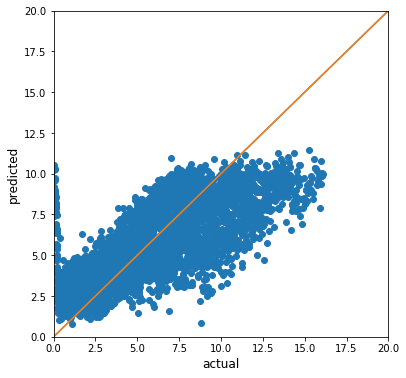

In [76]:
plt.figure(figsize=(6, 6))
plt.scatter(y_train.values.flatten(), y_pred)
plt.xlim(0, 20)
plt.ylim(0, 20)
plt.xlabel('actual', fontsize=12)
plt.ylabel('predicted', fontsize=12)
plt.plot([(0, 0), (20, 20)], [(0, 0), (20, 20)])
plt.show()

In [77]:
score = mean_absolute_error(y_train.values.flatten(), y_pred)
print(f'Score: {score:0.3f}')
# 2.277 w/ log_diff, var
# 2.270 w/ log_diff
# 2.207 w/ log_diff + last 10% data::fnn TURNED IN WITH SCORE 1.612
# 2.173 increased epochs, increased layer width, added one layer, lowered learning rate
# 2.143 doubled epochs
# 2.169 doubled batch size
# 2.493 lowered learning to 0.001
# 2.111 back to 0.025 lr, doubled epochs
# 2.108 added layer w/ 40 nodes
# 2.081 added 10 nodes to layer 1 TURNED IN WITH LOWER SCORE 1.631
# 2.121 Lowered epocks 
# 1.884 Added back in ptp, var, and fft features
# 1.594 fft increased from 20 to 50 features
# 0.065 Large network with 10% features added, total 113 TURNED IN WITH SCORE 2.017
# 1.903 Added droppout and reduced features to 88 TURNED IN WITH SCORE 1.747
# Same features with svm TURNED IN WITH LOWER SCORE NOPE
# 1.929 Added regularization, reduced layer size TURNED IN WITH SCORE 1.84
# 1.653 Increased fft to 100 TURNED IN WITH SCORE 1.913
# 1.444 50 fft real and 50 fft imag
# 1.380 reduced net size to 3 layers of 50, epochs to 300, and dropout to 0.2
# 2.341 lightgbm model using grandmaster parameters
# 1.230 Took out regularization TURNED IN WITH SCORE 1.902
# 1.813 Dropout to 0.3, reduced layer size to 30 30 30 TURNED IN WITH SCORE 1.951
# 1.609 Increased epochs to 500
# 1.614 Feature changes (more percentiles and took out variance and max/min) with weight information
# 1.580 Added fft and ffti percentiles COMMIT
# 1.771 Removed third layer
# 1.363 Added smoothed data peaks wow
# 1.485 Added zero crossings TURNED IN WITH SCORE 2.064
# 1.925 Same as above with SVM TURNED IN WITH SCORE 1.675
# 1.795 Two layers of size 20, 300 epochs
# 1.661 Removed percentile features and added rolling zero crosses TURNED IN WITH SCORE 1.831
# 1.919 Same as above with SVM 
# 1.910 Added avg distance between peaks
# 2.161 lightgbm TURNED IN WITH SCORE 1.919
# 1.769 Reduced network and dropout 
# 1.715 SVR with nu = 1
# 1.712 changed gamma to scale commited
# 2.178 nu = 0.2 committed
# 1.909 nu = 0.5 committed

Score: 1.909


In [29]:
submission = pd.read_csv('../input/sample_submission.csv', index_col='seg_id')

In [30]:
X_test = pd.DataFrame(columns=X_train.columns, dtype=np.float64, index=submission.index)

In [31]:
for seg_id in X_test.index:
    seg = pd.read_csv('../input/test/' + seg_id + '.csv')
    seg_smooth = seg.rolling(10).mean()
    
    x = seg['acoustic_data'].values
    x_smooth = seg_smooth['acoustic_data'].values
    
    
    X_test.loc[seg_id, 'ave'] = x.mean()
    X_test.loc[seg_id, 'abs_mean'] = np.absolute(x).mean()
    X_test.loc[seg_id, 'std'] = x.std()
#     X_test.loc[seg_id, 'max'] = x.max()
#     X_test.loc[seg_id, 'min'] = x.min()
    X_test.loc[seg_id, 'log_diff'] = np.log(x.max()-x.min())
    
    X_test.loc[seg_id, 'kurt'] = scs.kurtosis(x)
    X_test.loc[seg_id, 'skew'] = scs.skew(x)
    
#     X_test.loc[seg_id, 'p25'] = np.percentile(x,0.25)
#     X_test.loc[seg_id, 'p50'] = np.percentile(x,0.50)
#     X_test.loc[seg_id, 'p75'] = np.percentile(x,0.75)
#     X_test.loc[seg_id, 'p80'] = np.percentile(x,0.80)
#     X_test.loc[seg_id, 'p85'] = np.percentile(x,0.85)
#     X_test.loc[seg_id, 'p90'] = np.percentile(x,0.90)
#     X_test.loc[seg_id, 'p95'] = np.percentile(x,0.95)
#     X_test.loc[seg_id, 'pinter'] = X_test.loc[seg_id, 'p75'] - X_test.loc[seg_id, 'p25']
    
    for i in range(0,10,2):
        temp_x = x[int(len(x)*i/10):int(len(x)*(i+2)/10)]
        temp_x_smooth = x_smooth[int(len(x)*i/10):int(len(x)*(i+2)/10)]
        X_test.loc[seg_id, 'ave{}'.format(10*i)] = temp_x.mean()
        X_test.loc[seg_id, 'std{}'.format(10*i)] = temp_x.std()
#         X_test.loc[seg_id, 'max{}'.format(10*i)] = x[int(len(x)*i/10):int(len(x)*(i+2)/10)].max()
#         X_test.loc[seg_id, 'min{}'.format(10*i)] = x[int(len(x)*i/10):int(len(x)*(i+2)/10)].min()
        X_test.loc[seg_id, 'log_diff{}'.format(10*i)] = np.log(temp_x.max()-temp_x.min())
        X_test.loc[seg_id, f'peaks_smooth{10*i}'] = len(sig.find_peaks(temp_x_smooth)[0])
        X_test.loc[seg_id, f'zeros_smooth{10*i}'] = ((temp_x_smooth[:-1] * temp_x_smooth[1:]) < 0).sum()
        X_test.loc[seg_id, f'peaks_diff_smooth{10*i}'] = np.mean(np.diff(sig.find_peaks(temp_range_smooth)[0]))
    
    freq = np.fft.fft(x, n=50).real
    freq_i = np.fft.fft(x, n=50).imag
    
    
    X_test.loc[seg_id, 'fftp80'] = np.percentile(freq,0.80)
    X_test.loc[seg_id, 'fftp85'] = np.percentile(freq,0.85)
    X_test.loc[seg_id, 'fftp90'] = np.percentile(freq,0.90)
    X_test.loc[seg_id, 'fftp95'] = np.percentile(freq,0.95)
    
    X_test.loc[seg_id, 'fftip80'] = np.percentile(freq_i,0.80)
    X_test.loc[seg_id, 'fftip85'] = np.percentile(freq_i,0.85)
    X_test.loc[seg_id, 'fftip90'] = np.percentile(freq_i,0.90)
    X_test.loc[seg_id, 'fftip95'] = np.percentile(freq_i,0.95)
    
    for idx, freq_val in enumerate(freq):
        X_test.loc[seg_id, 'fft_{}'.format(idx)] = freq_val
        
    for idx, freq_val in enumerate(freq_i):
        X_test.loc[seg_id, 'ffti_{}'.format(idx)] = freq_val
    
    X_test.loc[seg_id, 'peaks_smooth'] = len(sig.find_peaks(x_smooth)[0])
    X_test.loc[seg_id, 'zeros_smooth'] = ((x_smooth[:-1] * x_smooth[1:]) < 0).sum()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in less
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:61: RuntimeWarning: invalid value encountered in less


In [32]:
X_test.head()

,ave,std,fft_0,fft_1,fft_2,fft_3,fft_4,fft_5,fft_6,fft_7,fft_8,fft_9,fft_10,fft_11,fft_12,fft_13,fft_14,fft_15,fft_16,fft_17,fft_18,fft_19,abs_mean,log_diff,kurt,skew,ave0,std0,log_diff0,peaks_smooth0,zeros_smooth0,peaks_diff_smooth0,ave20,std20,log_diff20,peaks_smooth20,zeros_smooth20,peaks_diff_smooth20,ave40,std40,...,ffti_12,ffti_13,ffti_14,ffti_15,ffti_16,ffti_17,ffti_18,ffti_19,ffti_20,ffti_21,ffti_22,ffti_23,ffti_24,ffti_25,ffti_26,ffti_27,ffti_28,ffti_29,ffti_30,ffti_31,ffti_32,ffti_33,ffti_34,ffti_35,ffti_36,ffti_37,ffti_38,ffti_39,ffti_40,ffti_41,ffti_42,ffti_43,ffti_44,ffti_45,ffti_46,ffti_47,ffti_48,ffti_49,peaks_smooth,zeros_smooth
seg_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
seg_00030f,4.491780,4.893673,254.0,-3.319525,-20.728598,80.584637,-8.299891,3.298374,31.913591,-8.097701,-24.760416,-31.212905,6.500000,14.619558,20.423540,1.250528,8.580158,-21.298374,-5.945657,-5.334304,-12.268287,-12.983360,5.224607,5.247024,28.836567,0.327904,4.501200,6.181731,5.247024,3689.0,298.0,6.876175,4.488967,4.159521,4.330733,3794.0,206.0,6.876175,4.489433,4.741746,...,3.346482,-12.357964,-8.007109,21.564029,5.132729,11.716240,6.147031,-0.161808,15.539687,-4.096285,-8.055016,7.036576,18.975138,-8.881784e-15,-18.975138,-7.036576,8.055016,4.096285,-15.539687,0.161808,-6.147031,-11.716240,-5.132729,-21.564029,8.007109,12.357964,-3.346482,-46.444286,-44.283384,-29.435457,-3.777480,8.533951,-14.183617,-22.527597,-37.308796,-131.182236,-29.592679,9.542860,18774.0,1296.0
seg_0012b5,4.171153,5.922820,209.0,23.093759,-16.046699,-61.335659,36.115603,31.697561,-18.449304,10.260912,-19.594092,-11.476950,0.545085,18.123247,-11.396905,-1.826485,24.988325,-5.197561,8.965465,-14.180999,13.563489,12.721962,5.198340,5.676754,56.217041,0.295705,4.017900,5.161684,4.718499,3891.0,274.0,6.876175,4.137700,8.559397,5.676754,3485.0,504.0,6.876175,4.171700,4.736224,...,-17.011378,12.648766,-2.972819,-9.220539,-3.658732,5.356349,5.616267,-10.752873,-10.824893,6.467664,2.880041,4.049916,-2.735203,-1.776357e-15,2.735203,-4.049916,-2.880041,-6.467664,10.824893,10.752873,-5.616267,-5.356349,3.658732,9.220539,2.972819,-12.648766,17.011378,36.820266,-8.004480,6.164712,-0.451486,26.765915,6.207469,42.499784,97.447474,-7.628221,-71.283406,-35.130071,19088.0,1618.0
seg_00184e,4.610260,6.946967,210.0,24.989931,-3.460677,11.118656,-21.256362,-12.961493,23.516217,-29.427422,5.864547,-8.244729,14.572949,39.014307,-11.585978,-12.169548,2.735900,19.461493,23.506676,-0.392655,-3.646240,2.403952,5.597193,6.089045,162.112840,0.428684,4.467300,10.495224,6.089045,4004.0,280.0,6.876175,4.754700,7.426129,5.497168,3757.0,275.0,6.876175,4.729300,5.181521,...,19.853751,-14.530368,-5.912408,18.604858,7.423380,-0.273084,-4.676648,4.427817,-6.208368,-9.813725,-5.612174,1.413613,4.805265,0.000000e+00,-4.805265,-1.413613,5.612174,9.813725,6.208368,-4.427817,4.676648,0.273084,-7.423380,-18.604858,5.912408,14.530368,-19.853751,12.002158,-9.094293,-24.069578,3.775483,2.929676,-12.679662,0.330515,6.198940,8.943355,-7.389341,46.772511,19697.0,1199.0
seg_003339,4.531473,4.114133,227.0,9.775411,-18.246006,-5.980749,-10.538334,-24.916408,-0.130429,-4.160394,-20.989737,-2.593643,26.534442,6.498703,-0.454874,10.705448,-6.008928,1.916408,-3.174933,1.122593,10.986377,-9.389905,4.961487,5.181784,41.240413,0.061889,4.392533,3.704752,4.043051,4365.0,159.0,6.876175,4.680733,4.393253,4.762174,4358.0,142.0,6.876175,4.608967,5.214383,...,-21.248799,1.357387,13.859773,-6.069610,-11.432023,-0.908033,-11.512775,-13.444697,2.991927,15.229352,-2.952309,0.365636,-9.898795,8.881784e-16,9.898795,-0.365636,2.952309,-15.229352,-2.991927,13.444697,11.512775,0.908033,11.432023,6.069610,-13.859773,-1.357387,21.248799,-16.423924,5.792096,26.677619,2.022437,3.977798,-10.068076,5.065553,6.447494,31.671617,1.783595,-11.309352,22166.0,610.0
seg_0042cc,4.128340,5.797144,218.0,4.483136,10.655952,-13.043784,10.865419,5.163119,-17.927681,5.910628,23.922705,7.689221,3.427051,-0.368616,

In [33]:
X_test_scaled = scaler.transform(X_test)
print(X_test_scaled.size)
# print(X_test_scaled[:10])
# print(model.predict(X_test_scaled))
submission['time_to_failure'] = svm.predict(X_test_scaled)
submission.to_csv('submission.csv')

383104


In [ ]:
sub = pd.read_csv('submission.csv')
sub[:100]